In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="/content/data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="/content/data", train=False, download=True, transform=transform)

batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


In [4]:
class AutoEncoderMNIST(nn.Module):
    def __init__(self, hidden_dim=28):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        h = self.encoder(x)
        x_recon = self.decoder(h)
        return x_recon, h

In [5]:
def show_reconstructions_inline(model, loader, n=10):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs[:n].to(device)
        x = imgs.view(n, -1)
        recon, _ = model(x)
        recon = recon.view(n, 1, 28, 28).detach().cpu()
        imgs = imgs.detach().cpu()

    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i,0], cmap="gray")
        plt.axis("off")
        if i == 0: plt.title("Orig", fontsize=10)

        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i,0], cmap="gray")
        plt.axis("off")
        if i == 0: plt.title("Reconstructed", fontsize=10)
    plt.show()

def live_plot(loss_hist, title="Train loss"):
    plt.figure(figsize=(6,4))
    plt.plot(loss_hist)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, alpha=0.3)
    plt.show()

In [6]:
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    for imgs, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        x = imgs.view(imgs.size(0), -1)
        recon, _ = model(x)
        loss = criterion(recon, x)
        total += loss.item()
    return total / len(loader)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for imgs, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        x = imgs.view(imgs.size(0), -1)

        optimizer.zero_grad()
        recon, _ = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()

        total += loss.item()
    return total / len(loader)

Epoch 10/10 | train=0.011355 | test=0.010744


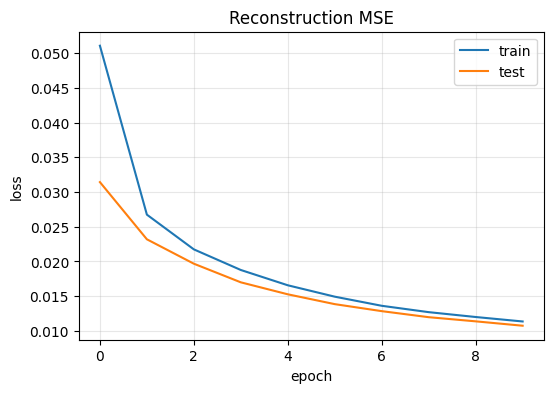

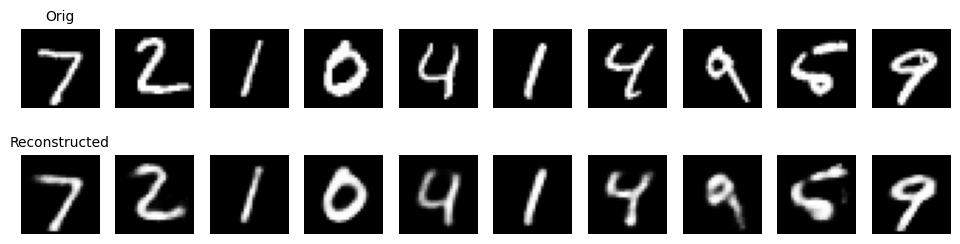

In [8]:
model = AutoEncoderMNIST(hidden_dim=28).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

train_loss_hist = []
test_loss_hist = []

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss  = eval_epoch(model, test_loader, criterion, device)

    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

    clear_output(wait=True)
    print(f"Epoch {epoch}/{epochs} | train={train_loss:.6f} | test={test_loss:.6f}")

    plt.figure(figsize=(6,4))
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.title("Reconstruction MSE")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    show_reconstructions_inline(model, test_loader, n=10)

In [9]:
torch.save(model.state_dict(), "/content/ae_mnist.pth")
print("Saved:", "/content/ae_mnist.pth")

Saved: /content/ae_mnist.pth
